In [11]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 30 10:51:32 2020

@author: Dypole_Imaging
"""
import numpy as np
import mysql.connector
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import pandas as pd


"""
imageID of P = 100mW / 2.5GHz red / spin mixuture 77939 - 78010
imageID of P = 100mW / 2.5GHz red / non spin polarized 78013 - 
"""

MYSQLserverIP = "192.168.1.133"
username = "root"
password = "w0lfg4ng"
databaseName = "dypoledatabase"

typeOfConnection = "global"
#### Used functions ####

def dataToArray(pathFile):
    # Convert camera fits data to binary format
    with open(pathFile, 'rb') as file:
        image = fits.getdata(file)
    return image[0].ravel().tolist(), image[1].ravel().tolist(), image[2].ravel().tolist()   # atoms, noAtoms, dark

def updateNewImage():
    db = setConnection()
    cursor = db.cursor()
    sql_query = """UPDATE updates SET newImage = 1 WHERE idUpdates = 0;"""
    cursor.execute(sql_query)
    db.commit()
    cursor.close()
    db.close()

def getLastID():
    sql_query = """SELECT runID FROM ciceroOut ORDER BY runID DESC LIMIT 1;"""
    lastRunID = executeGetQuery(sql_query)[0][0]
    sql_query = """SELECT sequenceID FROM sequence ORDER BY sequenceID DESC LIMIT 1;"""
    lastSequenceID = executeGetQuery(sql_query)[0][0]
    return lastRunID, lastSequenceID

def getLastImageID():
    sql_query = """SELECT imageID FROM images ORDER BY imageID DESC LIMIT 1;"""
    lastImageID = executeGetQuery(sql_query)[0][0]
    return lastImageID

def getTimestamp(imageID):
    sql_query = "SELECT timestamp FROM images WHERE imageID = " + str(imageID) + ";"
    timestamp = executeGetQuery(sql_query)[0][0]
    return timestamp

def getLastImageIDs(n):
    sql_query = """SELECT imageID FROM images ORDER BY imageID DESC LIMIT """ + str(n) + """;"""
    lastImageIDsTupleList = executeGetQuery(sql_query)
    lastImageIDs = listTupleToList(lastImageIDsTupleList)
    return lastImageIDs

def listTupleToList(List):
    outputList = []
    for oneTuple in List:
        outputList += [oneTuple[0]]
    return outputList

def setConnection(typeOfConnection = 'global'):
    if typeOfConnection == 'local':
        return setLocalConnection()
    elif typeOfConnection == 'global':
        return setDistantConnection()
    else:
        print('Set what type of connection you want')

def setLocalConnection():
    # Open database connection
    mydb = mysql.connector.connect(host = "localhost",
                        user = "student",
                        password = "w0lfg4ng",
                        database = "imagesdypoledatabase")
    #print('Local connection established')
    return mydb

def setDistantConnection():
    # Open database connection
    mydb = mysql.connector.connect(host = MYSQLserverIP,
                        user = username,
                        password = password,
                        database = databaseName)
    #print('Distant connection established')
    return mydb

def getRunIDFromImageID(imageID):
    sql_query = "SELECT runID_fk FROM images WHERE imageID = {} ;".format(imageID)
    runID_fk = executeGetQuery(sql_query)[0][0]
    return runID_fk

def getNCount(imageID):
    try:
        runID_fk = getRunIDFromImageID(imageID)
        sql_query = "SELECT nCount FROM nCounts WHERE runID_fk = {} ;".format(runID_fk)
        nCount = executeGetQuery(sql_query)[0][0]
    except:
        nCount = 0.0
    return nCount

def executeGetQuery(sql_query): # works when you don't need to use db.commit, so for read only functions
    db = setConnection()
    cursor = db.cursor()
    cursor.execute(sql_query)
    cursorResult = cursor.fetchall()
    cursor.close()
    db.close()
    return cursorResult    
    
def saveLocally(nCountArray, holdtimeArray, filename = 'data'):
    filename += '.npy'
    file = open(filename, 'wb')
    np.save(np.array([nCountArray, holdtimeArray]), file, allow_pickle = True)

In [6]:
getNCount(89594)

0.0

In [12]:
def getNCountList(imageIDList):
    NCounts = np.zeros(len(imageIDList))
    i = 0
    for imageID in imageIDList:
        NCounts[i] = getNCount(imageID)
        i += 1
    return NCounts

def getHoldTime(imageID):
    runID = getRunIDFromImageID(imageID)
    sql_query = "SELECT BECHoldTime FROM ciceroOut WHERE runID = {} ;".format(runID)
    holdTime = executeGetQuery(sql_query)[0][0]
    return float(holdTime)

def getHoldTimeList(imageIDList):
    holdTimeList = np.zeros(len(imageIDList))
    i = 0
    for imageID in imageIDList:
        holdTimeList[i] = getHoldTime(imageID)
        i += 1
    return holdTimeList

def createDataFrame(imageIDList):
    df_size = len(imageIDList)
    dictionnary = {'imageID' : [], 'BECHoldTime' : [], 'TOF' : [], 'nCount' : []}
    df = pd.DataFrame(dictionnary)
    for imageID in imageIDList:
        runID = getRunIDFromImageID(imageID)
        sql_query = "SELECT BECHoldTime, TOF FROM ciceroOut WHERE runID = {} ;".format(runID)
        BECHoldTime, TOF = executeGetQuery(sql_query)[0][:]
        sql_query = "SELECT nCount FROM nCounts WHERE runID_fk = {} ;".format(runID)
        nCount = executeGetQuery(sql_query)[0][0]
        df = df.append({'imageID' : int(round(imageID)), 'BECHoldTime' : BECHoldTime, 'TOF' : TOF, 'nCount' : nCount}, ignore_index = True)
    return df

In [ ]:
imageIDList_Mixture_data = np.array(list(range(89594,89688+1)))
NCountList_Mixture_data = getNCountList(imageIDList_Mixture_data)
holdTimeList_Mixture_data = getHoldTimeList(imageIDList_Mixture_data)

imageIDList_Polarized_data = np.array(list(range(89806,89901+1)))
NCountList_Polarized_data = getNCountList(imageIDList_Polarized_data)
holdTimeList_Polarized_data = getHoldTimeList(imageIDList_Polarized_data)

In [ ]:
imageIDList = np.array(list(range(89594,89688+1))+list(range(89806,89901+1)))
df = createDataFrame(imageIDList)

In [ ]:
labels = {'1GHz' : [89594, 89688], '2GHz' : [89594, 89688]}
range(labels['1GHz'])

In [13]:
"""imageIDList_Mixture_data = np.array(list(range(89594,89688+1)))
df_size = len(imageIDList_Mixture_data)
dictionnary = {'imageID' : imageIDList_Mixture_data, 'BECHoldtime' : [np.nan]*df_size,
               'TOF' : [np.nan]*df_size, 'nCount' : [np.nan]*df_size}
df = pd.DataFrame(dictionnary)
df = df.append({'imageID':5, 'nCount':2}, ignore_index = True)
"""

# [detuning, field direction], [imageID_start, imageID_end]
labels = [[['1GHz', 'Bz', 3], [89200, 89295]],
          [['1GHz', 'Bz', 2], [89297, 89391]],
          [['1GHz', 'By', 3], [89396, 89491]],
          [['1GHz', 'By', 2], [89494, 89588]],
          [['1.5GHz', 'Bz', 3], [89594, 89688]],
          [['1.5GHz', 'Bz', 2], [89806, 89901]],
          [['1.5GHz', 'By', 3], [89904, 89999]],
          [['1.5GHz', 'By', 2], [90000, 90097]], # This last one is uncertain
          [['2GHz', 'By', 3], [90101, 90195]],
          [['2GHz', 'By', 4], [90206, 90300]],
         ]
excluded = [89934, 90046, 90051, 90052]
excluded += [89416, 89418, 89877, 89241]  # My own findings

def createLabeledDataFrame(labels):
    imageIDList = []
    for label in labels:
        imageIDList += list(range(label[1][0], label[1][1]+1))
    detuning = []
    field_direction = []
    TOF = []
    for imageID in imageIDList:
        for label in labels:
            if imageID in range(label[1][0], label[1][1]+1):
                detuning += [label[0][0]]
                field_direction += [label[0][1]]
                TOF += [label[0][2]]
    df = createDataFrame(imageIDList)
    df['detuning'] = detuning
    df['field_direction'] = field_direction
    df['TOF'] = TOF
    return df

In [44]:
df = createLabeledDataFrame(labels)
df['BECHoldTime'] = df['BECHoldTime'].astype(float)
#df.to_pickle('data_save.pickle')

In [14]:
df = pd.read_pickle('data_save.pickle')
df

,imageID,BECHoldTime,TOF,nCount,detuning,field_direction
0,89200.0,18.0,3,23144.0,1GHz,Bz
1,89201.0,10.0,3,36880.0,1GHz,Bz
2,89202.0,20.0,3,17243.0,1GHz,Bz
3,89203.0,4.0,3,45040.0,1GHz,Bz
4,89204.0,2.5,3,60430.0,1GHz,Bz
...,...,...,...,...,...,...
952,90296.0,8.0,4,59973.0,2GHz,By
953,90297.0,0.5,4,87060.0,2GHz,By
954,90298.0,5.0,4,67831.0,2GHz,By
955,90299.0,20.0,4,45097.0,2GHz,By


In [15]:
# Delete these row indexes from dataFrame

indexNames = pd.Index(np.where(df['imageID'].isin(excluded))[0])
df.drop(indexNames, inplace = True)
df

,imageID,BECHoldTime,TOF,nCount,detuning,field_direction
0,89200.0,18.0,3,23144.0,1GHz,Bz
1,89201.0,10.0,3,36880.0,1GHz,Bz
2,89202.0,20.0,3,17243.0,1GHz,Bz
3,89203.0,4.0,3,45040.0,1GHz,Bz
4,89204.0,2.5,3,60430.0,1GHz,Bz
...,...,...,...,...,...,...
952,90296.0,8.0,4,59973.0,2GHz,By
953,90297.0,0.5,4,87060.0,2GHz,By
954,90298.0,5.0,4,67831.0,2GHz,By
955,90299.0,20.0,4,45097.0,2GHz,By


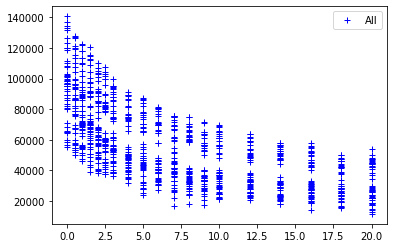

In [16]:
plt.figure()
plt.plot(df['BECHoldTime'], df['nCount'], '+', color = 'blue', label = 'All')
plt.legend()
plt.show()

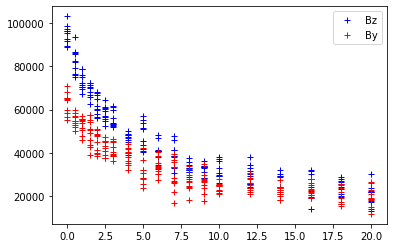

In [17]:
run = df[df['detuning'] == '1GHz']
run1 = run[run['field_direction'] == 'Bz']
run2 = run[run['field_direction'] == 'By']
plt.figure()
plt.plot(run1['BECHoldTime'], run1['nCount'], '+', color = 'blue', label = 'Bz')
plt.plot(run2['BECHoldTime'], run2['nCount'], '+', color = 'red', label = 'By')
plt.legend()
plt.show()

We fit the polarized sample to $dN/dt = -\alpha N-\gamma N^{3}$, so $N(t) = \frac{\sqrt{\alpha}}{\sqrt{e^{2\alpha t}\left(\frac{a}{N(0)^{2}}+\gamma\right)-\gamma}}$ and the mixture one to $dN/dt = -\alpha N - \beta N^{2} -\gamma N^{3}$, so $N(t) = complicated$

In [49]:
max(df['BECHoldTime'])

20.0

In [18]:
def N_polarized(t, N0, alpha, gamma):
    return np.sqrt(alpha / (np.exp(2*alpha*t)*(alpha/(N0**2)+gamma)-gamma))

def fitRun(detuning = '1GHz', field_direction = 'Bz', TOF = 3):
    df_reduced1 = df[df['detuning'] == detuning]
    df_reduced2 = df_reduced1[df_reduced1['TOF'] == TOF]
    df_reduced = df_reduced2[df_reduced2['field_direction'] == field_direction]
    N0_guess = max(df_reduced['nCount'])
    time_guess = max(df_reduced['BECHoldTime'])
    popt, pcov = curve_fit(N_polarized, df_reduced['BECHoldTime'], df_reduced['nCount'],
                       p0 = [N0_guess, 1/time_guess, 1/(N0_guess**2*time_guess)],
                       method = 'lm'
                      )
    return popt, pcov

results = []
"""results = pd.DataFrame({'detuning' : [],
                        'TOF' : [],
                        'field_direction' : [],
                        'N0' : [],
                        'alpha' : [],
                        'gamma' : []})"""

for run in labels:
    detuning, field_direction, TOF = run[0]
    print(detuning, field_direction, TOF)
    popt, pcov = fitRun(detuning, field_direction, TOF)
    results += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'field_direction' : field_direction,
                        'N0' : popt[0],
                        'alpha' : popt[1],
                        'gamma' : popt[2]}]
resultsDF = pd.DataFrame(results)

#perr = np.sqrt(np.diag(pcov))

1GHz Bz 3
1GHz Bz 2
1GHz By 3
1GHz By 2
1.5GHz Bz 3
1.5GHz Bz 2
1.5GHz By 3
1.5GHz By 2
2GHz By 3
2GHz By 4


In [19]:
resultsDF

,detuning,TOF,field_direction,N0,alpha,gamma
0,1GHz,3,Bz,95792.914338,0.015256,3.413948e-11
1,1GHz,2,Bz,94252.641311,0.022246,3.385118e-11
2,1GHz,3,By,66137.258478,0.000060,5.883945e-11
3,1GHz,2,By,59851.408005,0.001231,6.467527e-11
4,1.5GHz,3,Bz,122923.621053,0.013027,8.981407e-12
5,1.5GHz,2,Bz,132981.405173,0.011172,7.584362e-12
6,1.5GHz,3,By,96535.480370,-0.000191,3.246966e-11
7,1.5GHz,2,By,80647.812479,-0.004859,3.544965e-11
8,2GHz,3,By,101654.548007,0.003417,9.676666e-12
9,2GHz,4,By,102185.108737,-0.002518,1.252102e-11


We notice the decay is nearly 3-body in all case. To ensure that we can look at $\alpha N_{0}/(\gamma*N_{0}^{3})$ which at $t=0$ is never above a 10\%. So let's just fit to a 3body decay curve.
$dN/dt = -\gamma N^{3}$, so $N(t) = \frac{N_{0}}{\sqrt{1+N_{0}^{2}\gamma t}}$.

In [20]:
resultsDF['alpha']*resultsDF['N0']/(resultsDF['gamma']*(resultsDF['N0']**3))

0    0.048698
1    0.073976
2    0.000233
3    0.005313
4    0.095988
5    0.083299
6   -0.000630
7   -0.021073
8    0.034174
9   -0.019262
dtype: float64

In [21]:
def N_polarized_pure3b(t, N0, gamma):
    return N0 / np.sqrt(1+N0**2*gamma*t)

def getReducedDataframe(df, detuning = None, field_direction = None, TOF = None):
    df_temporary = df
    if detuning:
        df_temporary = df_temporary[df_temporary['detuning'] == detuning]
    if field_direction:
        df_temporary = df_temporary[df_temporary['field_direction'] == field_direction]
    if TOF:
        df_temporary = df_temporary[df_temporary['TOF'] == TOF]
    return df_temporary

def getReducedResults(results, detuning = None, field_direction = None, TOF = None):
    df_temporary = results
    if detuning:
        df_temporary = df_temporary[df_temporary['detuning'] == detuning]
    if field_direction:
        df_temporary = df_temporary[df_temporary['field_direction'] == field_direction]
    if TOF:
        df_temporary = df_temporary[df_temporary['TOF'] == TOF]
    return df_temporary

def fitRun(detuning = '1GHz', field_direction = 'Bz', TOF = 3):
    df_reduced = getReducedDataframe(df, detuning, field_direction, TOF)
    N0_guess = max(df_reduced['nCount'])
    time_guess = max(df_reduced['BECHoldTime'])
    popt, pcov = curve_fit(N_polarized_pure3b, df_reduced['BECHoldTime'], df_reduced['nCount'],
                       p0 = [N0_guess, 1/(N0_guess**2*time_guess)],
                       method = 'lm'
                      )
    return popt, pcov

results = []

for run in labels:
    detuning, field_direction, TOF = run[0]
    popt, pcov = fitRun(detuning, field_direction, TOF)
    results += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'field_direction' : field_direction,
                        'N0' : popt[0],
                        'gamma' : popt[1]}]
resultsDF_pure3b = pd.DataFrame(results)

#perr = np.sqrt(np.diag(pcov))

In [121]:
resultsDF_pure3b

,detuning,TOF,field_direction,N0,gamma
0,1GHz,3,Bz,97207.077787,8.020382e-11
1,1GHz,2,Bz,96366.624331,8.589299e-11
2,1GHz,3,By,66141.729284,1.177646e-10
3,1GHz,2,By,59933.515529,1.314346e-10
4,1.5GHz,3,Bz,124849.996734,2.243568e-11
5,1.5GHz,2,Bz,134755.778330,1.839881e-11
6,1.5GHz,3,By,96516.000147,6.479903e-11
7,1.5GHz,2,By,80173.385639,6.641373e-11
8,2GHz,3,By,102069.192965,2.081456e-11
9,2GHz,4,By,101872.186790,2.389683e-11


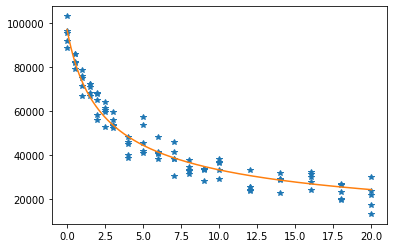

In [22]:
df_reduced = getReducedDataframe(df, detuning = '1GHz', field_direction = 'Bz', TOF = 3)
result_reduced = getReducedResults(resultsDF_pure3b, detuning = '1GHz', field_direction = 'Bz', TOF = 3)
holdTime = np.linspace(0,20, 300)
plt.figure()
plt.plot(df_reduced['BECHoldTime'], df_reduced['nCount'], '*')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced['N0'][0], result_reduced['gamma'][0]))
plt.show()

Now we should look at how much time we should shift:

In [23]:
def deltaTime(results, detuning, TOF):
    holdTime = np.linspace(0,20, 10000)
    results_Bz = getReducedResults(results, detuning, 'Bz', TOF)
    results_By = getReducedResults(results, detuning, 'By', TOF)
    N0_z, gamma_z = results_Bz['N0'].iloc[0], results_Bz['gamma'].iloc[0]
    N0_y, gamma_y = results_By['N0'].iloc[0], results_By['gamma'].iloc[0]
    index = np.argmin(np.abs(N_polarized_pure3b(holdTime, N0_z, gamma_z)-N_polarized_pure3b(0, N0_y, gamma_y)))
    return holdTime[index]

deltaTime(resultsDF_pure3b, '1GHz', 3)

1.5301530153015301

Now we can calculate the ration of the beta, provided the derivative of the N_polarized_pure3b function: $\frac{dN}{dt} = -\frac{1}{2}N_{0}^{3}\gamma\left(1+N_{0}^{2}\gamma t\right)^{-3/2}$

In [24]:
def dN_polarized_pure3b_dt(t, N0, gamma):
    return -0.5*N0**3*gamma*(1+N0**2*gamma*t)**(-3/2)

def getBeta(results, detuning, field_direction, TOF):
    temp = results[results['detuning'] == detuning]
    temp = temp[temp['TOF'] == TOF]
    return temp[temp['field_direction'] == field_direction]['gamma']

results_betaRatio = []
for detuning in ['1GHz', '1.5GHz']:
    for TOF in [2, 3]:
        print(detuning, TOF)
        beta_y_init = getBeta(resultsDF_pure3b, detuning, 'By', TOF)
        beta_z_init = getBeta(resultsDF_pure3b, detuning, 'Bz', TOF)
        dt = deltaTime(resultsDF_pure3b, detuning, TOF)
        
        results_By = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)
        results_Bz = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
        N0_y, gamma_y = results_By['N0'].iloc[0], results_By['gamma'].iloc[0]
        N0_z, gamma_z = results_Bz['N0'].iloc[0], results_Bz['gamma'].iloc[0]
        
        beta_y = dN_polarized_pure3b_dt(0, N0_y, gamma_y)
        beta_z = dN_polarized_pure3b_dt(dt, N0_z, gamma_z)
        
        results_betaRatio += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'betaRatio' : beta_z/beta_y}]

results_betaRatio = pd.DataFrame(results_betaRatio)

results_betaRatio

1GHz 2
1GHz 3
1.5GHz 2
1.5GHz 3


,detuning,TOF,betaRatio
0,1GHz,2,0.653290
1,1GHz,3,0.681198
2,1.5GHz,2,0.277038
3,1.5GHz,3,0.346141


In [70]:
detuning = '1GHz'
TOF = 3
beta_y_init = getBeta(resultsDF_pure3b, detuning, 'By', TOF)  # this is the gamma from the fit
beta_z_init = getBeta(resultsDF_pure3b, detuning, 'Bz', TOF)
dt = deltaTime(resultsDF_pure3b, detuning, TOF)

print(dN_polarized_pure3b_dt(0, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]))
print(dN_polarized_pure3b_dt(dt, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]))
print(dN_polarized_pure3b_dt(0, result_reduced_y['N0'].iloc[0], result_reduced_y['gamma'].iloc[0]))

results_By = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)  # this is the full results of a fit
results_Bz = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
N0_y, gamma_y = results_By['N0'].iloc[0], results_By['gamma'].iloc[0]
N0_z, gamma_z = results_Bz['N0'].iloc[0], results_Bz['gamma'].iloc[0]
        
beta_y = dN_polarized_pure3b_dt(0, N0_y, gamma_y)
beta_z = dN_polarized_pure3b_dt(dt, N0_z, gamma_z)
#beta_z/beta_y
print(beta_y)
print(beta_z)


-36834.83263911268
-11606.05584929771
-17037.716809472666
-17037.716809472666
-11606.05584929771


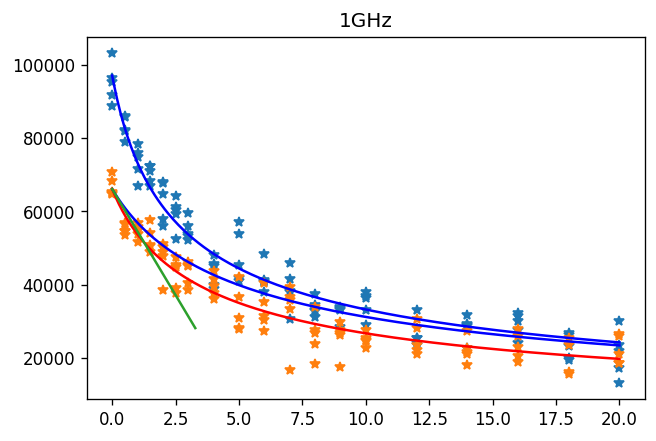

In [76]:
detuning = '1GHz'
TOF = 3
dt = deltaTime(resultsDF_pure3b, detuning, TOF)
df_reduced_z = getReducedDataframe(df, detuning,'Bz', TOF)
df_reduced_y = getReducedDataframe(df, detuning,'By', TOF)
result_reduced_z = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
result_reduced_y = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)

dNdt = dN_polarized_pure3b_dt(dt, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0])
holdTime = np.linspace(0,20, 300)
Y1 = result_reduced_y['N0'].iloc[0] + holdTime*dNdt
Y2 = N_polarized_pure3b(dt, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]) + (holdTime-dt)*dNdt
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount'], '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount'], '*')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]), color = 'blue')
plt.plot(holdTime, N_polarized_pure3b(holdTime+dt, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]), color = 'blue')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_y['N0'].iloc[0], result_reduced_y['gamma'].iloc[0]), color = 'red')
plt.plot(holdTime[:50], Y1[:50])
#plt.plot(holdTime[:50], Y2[:50])
plt.title('1GHz')
plt.show()

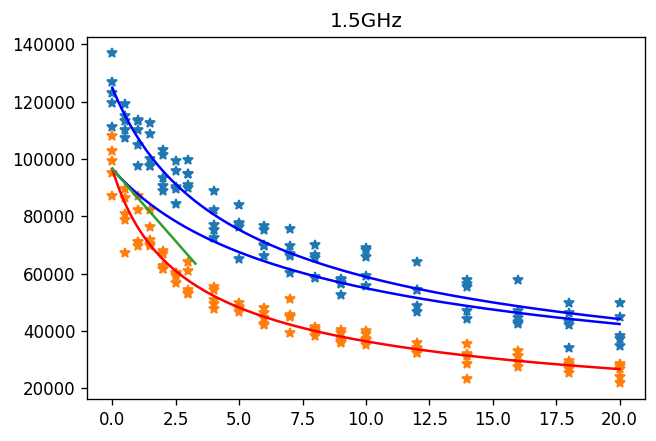

In [75]:
detuning = '1.5GHz'
TOF = 3
dt = deltaTime(resultsDF_pure3b, detuning, TOF)
df_reduced_z = getReducedDataframe(df, detuning,'Bz', TOF)
df_reduced_y = getReducedDataframe(df, detuning,'By', TOF)
result_reduced_z = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
result_reduced_y = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)

dNdt = dN_polarized_pure3b_dt(dt, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0])
holdTime = np.linspace(0,20, 300)
Y1 = result_reduced_y['N0'].iloc[0] + holdTime*dNdt
Y2 = N_polarized_pure3b(dt, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]) + (holdTime-dt)*dNdt
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount'], '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount'], '*')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]), color = 'blue')
plt.plot(holdTime, N_polarized_pure3b(holdTime+dt, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]), color = 'blue')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_y['N0'].iloc[0], result_reduced_y['gamma'].iloc[0]), color = 'red')
plt.plot(holdTime[:50], Y1[:50])
#plt.plot(holdTime[:50], Y2[:50])
plt.title('1.5GHz')
plt.show()

In [50]:
print(dN_polarized_pure3b_dt(0, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]))
print(dN_polarized_pure3b_dt(dt, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]))
print(dN_polarized_pure3b_dt(0, result_reduced_y['N0'].iloc[0], result_reduced_y['gamma'].iloc[0]))

-36834.83263911268
-11606.05584929771
-17037.716809472666


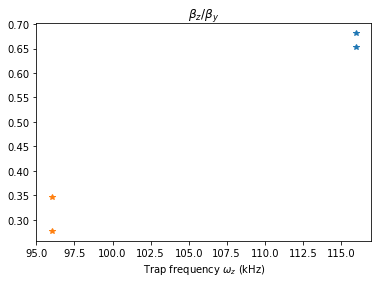

In [180]:
points1G = results_betaRatio[results_betaRatio['detuning'] == '1GHz']['betaRatio']
points15G = results_betaRatio[results_betaRatio['detuning'] == '1.5GHz']['betaRatio']

plt.figure()
plt.plot([116, 116], points1G, '*')
plt.plot([96, 96], points15G, '*')
plt.title(r'$\beta_{z}/\beta_{y}$')
plt.xlabel(r'Trap frequency $\omega_{z}$ (kHz)')
plt.show()

It doesn't look good at all, it should be reversed, the $\beta_{z}$ should be equal to $\beta_{y}$ for small $\omega_{z}$ and drop at the threshold.

1GHz 2
1GHz 3
1.5GHz 2
1.5GHz 3


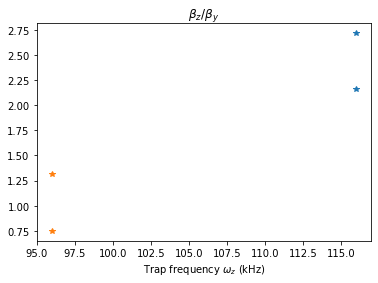

In [181]:
def dN_polarized_pure3b_dt(t, N0, gamma):
    return -0.5*N0**3*gamma*(1+N0**2*gamma*t)**(-3/2)

def getBeta(results, detuning, field_direction, TOF):
    temp = results[results['detuning'] == detuning]
    temp = temp[temp['TOF'] == TOF]
    return temp[temp['field_direction'] == field_direction]['gamma']

results_betaRatio = []
for detuning in ['1GHz', '1.5GHz']:
    for TOF in [2, 3]:
        print(detuning, TOF)
        beta_y_init = getBeta(resultsDF_pure3b, detuning, 'By', TOF)
        beta_z_init = getBeta(resultsDF_pure3b, detuning, 'Bz', TOF)
        dt = deltaTime(resultsDF_pure3b, detuning, TOF)
        
        results_By = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)
        results_Bz = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
        N0_y, gamma_y = results_By['N0'].iloc[0], results_By['gamma'].iloc[0]
        N0_z, gamma_z = results_Bz['N0'].iloc[0], results_Bz['gamma'].iloc[0]
        
        beta_y = dN_polarized_pure3b_dt(0, N0_y, gamma_y)
        beta_z = dN_polarized_pure3b_dt(0, N0_z, gamma_z)
        
        results_betaRatio += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'betaRatio' : beta_z/beta_y}]

results_betaRatio = pd.DataFrame(results_betaRatio)

results_betaRatio

points1G = results_betaRatio[results_betaRatio['detuning'] == '1GHz']['betaRatio']
points15G = results_betaRatio[results_betaRatio['detuning'] == '1.5GHz']['betaRatio']

plt.figure()
plt.plot([116, 116], points1G, '*')
plt.plot([96, 96], points15G, '*')
plt.title(r'$\beta_{z}/\beta_{y}$')
plt.xlabel(r'Trap frequency $\omega_{z}$ (kHz)')
plt.show()

In [ ]:
N0_guess = max(NCountList_Polarized)
time_guess = max(holdTimeList_Polarized)
NCountList_Polarized_truncated = NCountList_Polarized[holdTimeList_Polarized < 40]
holdTimeList_Polarized_truncated = holdTimeList_Polarized[holdTimeList_Polarized < 40]
N0_min = NCountList_Polarized[holdTimeList_Polarized == 0.5].mean()
popt_test, pcov_test = curve_fit(N_polarized, holdTimeList_Polarized_truncated, NCountList_Polarized_truncated,
                       p0 = [N0_guess, 1/time_guess, 1/(N0_guess**2*time_guess)],
                       method = 'trf'
                      )
perr = np.sqrt(np.diag(pcov))
print(popt_test)
print("The ratio between exponential decay / 3-body decay is " + str(round(popt[2]*(popt[0])**2/(popt[1]),1)))

In [ ]:
holdTimeList = np.linspace(0, 50, 200)
plt.figure()
plt.plot(holdTimeList_Polarized, NCountList_Polarized, '*', color = 'red', label = 'Polarized')
plt.plot(holdTimeList, N_polarized(holdTimeList, popt_test[0], popt_test[1], popt_test[2]), '-', color = 'black', label = 'fit')
#plt.plot(holdTimeList, N_polarized(holdTimeList, popt[0]*0.95, popt[1]*10, popt[2]*1.5), '--', color = 'black', label = 'fit')

plt.legend()
plt.show()

In [ ]:
alpha = 0.1
gamma = 0.01
def dNdt(t, N):
    return -alpha*N-gamma*N**3
Tau = np.linspace(0,50,1000)
sol = solve_ivp(dNdt, t_span = (0,100), y0 = (N0,), t_eval = Tau)

plt.figure()
plt.plot(sol.t, sol.y[0,:])
plt.show()

In [ ]:
def N_polarized_diff(t, N0, alpha, gamma):
    def dNdt(t, N):
        return -alpha*N-gamma*N**3
    #print(t)
    sol = solve_ivp(dNdt, t_span = (0,100), y0 = (N0,), t_eval = t)#, atol = 10**-20, method = 'DOP853')
    N = sol.y[0,:len(t)]
    return N
t = np.array(list(range(0,50, 1)))
N_t = N_polarized_diff(t, 1, 0.1, 0.1)

plt.figure()
plt.plot(t, N_t)
plt.plot(t, N_polarized(t, 1, 0.1, 0.1))
plt.show()

In [ ]:
N0_guess = max(NCountList_Polarized)
time_guess = max(holdTimeList_Polarized)

# it sadly only works if you do the mean previously
# holdTimeList_Polarized_sorted, NCountList_Polarized_sorted = zip(*sorted(zip(holdTimeList_Polarized+noise, NCountList_Polarized)))
holdTime = np.array([])
NCount = np.array([])
timeviewed = []
for time in holdTimeList_Polarized:
    if time in timeviewed:
        continue # go to the next iteration
    timeviewed += [time]
    holdTime = np.append(holdTime,[time])
    NCount = np.append(NCount,[NCountList_Polarized[holdTimeList_Polarized == time].mean()])

holdTime, NCount = zip(*sorted(zip(holdTime, NCount)))

In [ ]:
plt.figure()
plt.plot(holdTimeList_Polarized, NCountList_Polarized, '+')
plt.plot(holdTime, NCount, '-')
plt.show()

In [ ]:
N0_guess = max(NCount)
time_guess = max(holdTime)
popt_diff, pcov_diff = curve_fit(N_polarized_diff, holdTime, NCount,
                       p0 = [N0_guess, 1/time_guess, 1/(N0_guess**2*time_guess)],
                        bounds = ([0, 0, 0], [np.inf, np.inf, np.inf]),
                       method = 'trf'
                      )
perr_diff = np.sqrt(np.diag(pcov_diff))

t = np.linspace(0, 50, 1000)
y_diff = N_polarized_diff(t, popt_diff[0], popt_diff[1], popt_diff[2])
y_known = N_polarized(t, popt_diff[0], popt_diff[1], popt_diff[2])

plt.figure()
plt.plot(holdTimeList_Polarized, NCountList_Polarized, '+')
plt.plot(holdTime, NCount, 'o')
plt.plot(t, y_diff, label = "diff solution")
plt.plot(t, y_known, label = "known solution")
plt.legend()
plt.show()

In [ ]:
popt_diff

In [ ]:
perr_diff

In [ ]:
mydb = mysql.connector.connect(host = "localhost",
                        user = "student",
                        password = "w0lfg4ng",
                        database = "imagesdypoledatabase",
                        auth_plugin = 'mysql_native_password')
    #print('Local connection established')